In [3]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd, numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from nltk.stem.porter import PorterStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from nltk.tokenize import TreebankWordTokenizer, RegexpTokenizer, \
PunktSentenceTokenizer, WordPunctTokenizer
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder
import copy
import string
import operator
from stop_words import get_stop_words
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectKBest, chi2
import collections, itertools

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import time                                                
import pickle

def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

def pickle_dump(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

def pickle_load(filename):
    with open(filename, 'rb') as f:
        # https://stackoverflow.com/questions/28218466/unpickling-a-python-2-object-with-python-3
        return pickle.load(f)

In [7]:
def fetch_data():
    train = pd.read_csv('./csv/train_data.csv', encoding = 'UTF-8')
    test = pd.read_csv('./csv/test_data.csv', encoding = 'UTF-8')
    return train, test

In [8]:
def xy_seperator(df):
    X = df.iloc[:,0]
    y = df.iloc[:,1:].astype(str).replace({'T':1,'F':0})
    return X,y

In [9]:
def word_cloud(X, max_font_size=40):
    X1 = copy.deepcopy(X)
    if (any(isinstance(row, unicode) for row in X1)):
        X1 = X1.apply(lambda row: row.split(' '))
    text = []
    for sentence in X1:
        text.extend(sentence)
    textall = " ".join(text)
    wordcloud = WordCloud(max_font_size = max_font_size).generate(textall)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [10]:
def preprocess(listlikeobj, sw_curated = []):
    """Applies pre-processing pipelines to lists of string
    """
    en_stop = get_stop_words('en')
    tokenizer = TreebankWordTokenizer()
    p_stemmer = PorterStemmer()

    listlikeobj = listlikeobj.apply(lambda row: row.lower())
    listlikeobj = listlikeobj.apply(lambda row: tokenizer.tokenize(row))
    listlikeobj = listlikeobj.apply(lambda row: [i for i in row if i not in en_stop])
    listlikeobj = listlikeobj.apply(lambda row: [i for i in row if i not in string.punctuation])
    listlikeobj = listlikeobj.apply(lambda row: [p_stemmer.stem(i) for i in row])
    listlikeobj = listlikeobj.apply(lambda row: [i for i in row if i not in sw_curated])

    return listlikeobj

In [11]:
def vectorize(X_train, X_test, vectorizer = CountVectorizer(ngram_range=(1,2)),max_df = 0.5, min_df = 3):
    X_train = pd.Series([' '.join(sentence) for  sentence in X_train])
    X_test = pd.Series([' '.join(sentence) for  sentence in X_test])
    vectorizer.fit(X_train)
    train_dtm = vectorizer.transform(X_train)
    test_dtm = vectorizer.transform(X_test)
    freq = np.ravel(train_dtm.sum(axis=0))
    vocab = [v[0] for v in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]
    freq_sorted = dict(zip(vocab, freq))
    freq_dict = OrderedDict(sorted(freq_sorted.items(), key=operator.itemgetter(1)))
    wordfreq = pd.DataFrame({'word':freq_dict.keys(), 'count':freq_dict.values()})
    return train_dtm, test_dtm, vectorizer.get_feature_names(), wordfreq

In [12]:
def stop_word_removal(listlikeobj, sw=[]):
    listlikeobj = listlikeobj.apply(lambda row: [i for i in row if i not in sw])
    return listlikeobj

In [13]:
def label_accuracy(y_true, y_pred):
    """Compute label accuracy
    """
    res = (y_true.values == y_pred)
    return (res).sum().sum()/res.size

In [14]:
@timeit
def classify(train_dtm, y_train, model = RandomForestClassifier(random_state = 42)):
    model.fit(train_dtm, y_train)
    return model

In [15]:
@timeit
def grid_obj_creator(classifier, parameters, X, y):
    acc_scorer = make_scorer(accuracy_score)
    grid_obj = GridSearchCV(classifier, parameters, scoring=acc_scorer, n_jobs=-1)
    grid_obj = grid_obj.fit(X, y)
    return grid_obj 

In [16]:
def results(model, test_dtm, y_test):
    y_pred = model.predict(test_dtm)
    print('label accuracy', label_accuracy(y_test, y_pred))
    print ('subset accuracy', accuracy_score(y_test, y_pred))
    print ('classification report', classification_report(y_test, y_pred))

#### Processing before model fitting

In [17]:
train,test = fetch_data()

In [18]:
X_train, y_train = xy_seperator(train)
X_test, y_test = xy_seperator(test)

In [19]:
X_train.head()

0                                      7am everyday
1                                    chocolate cake
2    closed mortice and tenon joint door dimentions
3                               train eppo kelambum
4      yesterday i have cancelled the flight ticket
Name: message, dtype: object

In [20]:
y_train.head()

,food,recharge,support,reminders,travel,nearby,movies,casual,other
0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0


### EDA on train and Test

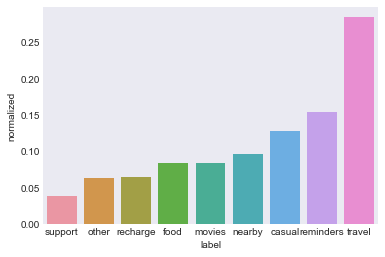

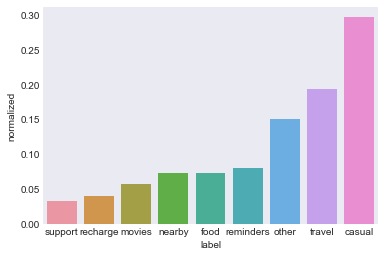

In [21]:
def plot_yhist(y):
    freq = np.ravel(y.sum(axis=0))
    freq = dict(zip(y.columns, freq))
    freq = OrderedDict(sorted(freq.items(), key=operator.itemgetter(1)))
    yhist = pd.DataFrame({'label':freq.keys(), 'count':freq.values()})
    yhist['normalized'] = yhist['count']/yhist['count'].sum()
    sns.set_style("dark")
    sns.set_palette("Reds")
    ax = sns.barplot(x="label", y="normalized", data=yhist)
    plt.show()
    
plot_yhist(y_train)
plot_yhist(y_test)

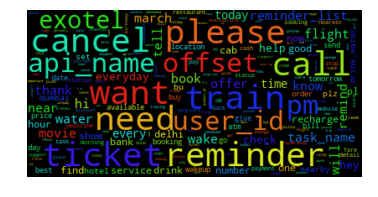

In [22]:
word_cloud(X_train)

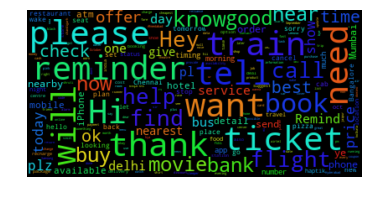

In [23]:
word_cloud(X_test)

### Word Clouds for Labels

#### wordcloud for Label Reminders

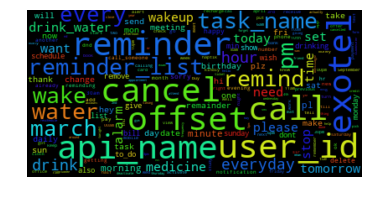

In [24]:
word_cloud(X_train[train['reminders'] == 'T'])

#### wordcloud for Label Travel

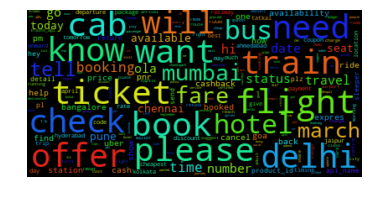

In [25]:
word_cloud(X_train[train['travel'] == 'T'])

#### wordcloud for Label Casual

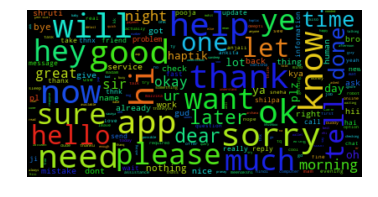

In [26]:
word_cloud(X_train[train['casual'] == 'T'])

In [27]:
def freq_count(X):
    word_freq = {}
    for sentence in X:
        for word in sentence.split(' '):
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
    
    df = pd.DataFrame(word_freq.items(), columns = ['word','freq'])
    return df.sort_values(by = 'freq', ascending = 0 )
    
word_freq = freq_count(X_train)


In [30]:
word_freq[0:40]

,word,freq
15514,to,10500
10792,i,7118
7516,for,5899
12862,me,5183
9317,the,4031
12879,my,3760
11250,in,3377
82,want,3068
8043,at,2868
16904,can,2836


In [34]:
word_freq.sort_values('freq')[0:40]

,word,freq
23906,lol..,1
8244,plam,1
8175,pegasus,1
8177,"671536,",1
8213,pooja😘😘😘,1
8214,"1983207,",1
8215,3adts?,1
8218,Class.,1
8219,relationship,1
8220,me...on,1


In [39]:
sw_ = ['a9c0', '676951', 'hi', 'task_nam',
              'user_id', '50', '16', 'exotel','ok', 'haptik', 'nearbi',
              'api_nam', 'offset', 'user_id', '00', 'pleas', 'can', 'pl',
              'drink_water', 'reminer_list', 'trains_api', 'product_id', 
              'I', 'j', 'se', 'sl', '10', 'hai', 'll', 'kya', 'rs', 'sorri',
              'know', '30', 'one', '10 00', 'bu', 'reminder_list',
              'plz', 'everi']

In [22]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)

In [23]:
X_train.head()

0                                [7am, everyday]
1                                 [chocol, cake]
2    [close, mortic, tenon, joint, door, diment]
3                        [train, eppo, kelambum]
4            [yesterday, cancel, flight, ticket]
Name: message, dtype: object

In [24]:
train_dtm, test_dtm, feature_names, word_freq = vectorize(X_train, X_test)

#### ITeration 1

In [63]:
train_dtm1 = copy.deepcopy(train_dtm)
test_dtm1 = copy.deepcopy(test_dtm)
y_train1 = copy.deepcopy(y_train)
y_test1 = copy.deepcopy(y_test)

In [64]:
model = classify(train_dtm1, y_train1)

'classify'  72639.00 ms


In [84]:
pickle_dump(model,'plain_rf.pkl')

In [65]:
results(model, test_dtm1, y_test1)

label accuracy 0.9411
subset accuracy 0.7129
classification report              precision    recall  f1-score   support

          0       0.80      0.59      0.68       810
          1       0.73      0.62      0.67       450
          2       0.62      0.25      0.35       371
          3       0.86      0.81      0.84       893
          4       0.80      0.81      0.81      2138
          5       0.68      0.59      0.63       807
          6       0.68      0.62      0.65       637
          7       0.79      0.87      0.83      3282
          8       0.93      0.45      0.61      1668

avg / total       0.80      0.70      0.73     11056



#### Iteration2 - with grid search and dim reduction for random forest

In [66]:
train_dtm2 = copy.deepcopy(train_dtm)
test_dtm2 = copy.deepcopy(test_dtm)
y_train2 = copy.deepcopy(y_train)
y_test2 = copy.deepcopy(y_test)

In [27]:
def reduce_dimensions(train_dtm, test_dtm, k=15000):
    """Reduce dimensionality"""
    ch2 = SelectKBest(chi2, k)
    ch2.fit(train_dtm, y_train)
    train_dtm = ch2.transform(train_dtm)
    test_dtm = ch2.transform(test_dtm)
    return train_dtm, test_dtm

In [68]:
train_dtm2, test_dtm2 = reduce_dimensions(train_dtm2, test_dtm2, k=16000)

In [69]:
rf = classify(train_dtm2, y_train2)

'classify'  19883.12 ms


In [82]:
pickle_dump(rf,'random_dim.pkl')

In [70]:
results(rf, test_dtm2, y_test2)

label accuracy 0.941666666667
subset accuracy 0.714
classification report              precision    recall  f1-score   support

          0       0.79      0.58      0.67       810
          1       0.73      0.61      0.67       450
          2       0.61      0.18      0.28       371
          3       0.85      0.84      0.84       893
          4       0.79      0.84      0.81      2138
          5       0.65      0.61      0.63       807
          6       0.73      0.59      0.66       637
          7       0.82      0.84      0.83      3282
          8       0.92      0.46      0.62      1668

avg / total       0.80      0.70      0.73     11056



In [71]:
# param_grid_rf = {"n_estimators": [150, 200],
#                   "max_depth": [2000, 2250, 2500, 2750, 3000],
#                   "min_samples_split": [4, 5, 6],
#                   "max_features": [0.005, 0.006, 0.007, 0.00735215, 0.008, 0.07, 0.2]}


In [73]:
# grid_output = grid_obj_creator(classifier = RandomForestClassifier(random_state=42), parameters = param_grid_rf, X = train_dtm2, y = y_train2)

#### Iteration 3 Extra Tree Classifier

In [78]:
train_dtm3 = copy.deepcopy(train_dtm)
test_dtm3 = copy.deepcopy(test_dtm)
y_train3 = copy.deepcopy(y_train)
y_test3 = copy.deepcopy(y_test)

In [79]:
ex = classify(train_dtm3, y_train3, model = ExtraTreesClassifier(n_estimators = 250, n_jobs = -1))

'classify'  1442181.69 ms


In [80]:
results(ex, test_dtm3, y_test3)

label accuracy 0.944977777778
subset accuracy 0.7351
classification report              precision    recall  f1-score   support

          0       0.79      0.60      0.69       810
          1       0.76      0.67      0.71       450
          2       0.58      0.23      0.33       371
          3       0.88      0.82      0.85       893
          4       0.83      0.83      0.83      2138
          5       0.69      0.62      0.65       807
          6       0.73      0.62      0.67       637
          7       0.81      0.86      0.83      3282
          8       0.93      0.51      0.66      1668

avg / total       0.81      0.72      0.75     11056



In [2]:
# pickle_dump(ex, 'extratree.pkl')

#### Iteration 4

In [25]:
train_dtm4 = copy.deepcopy(train_dtm)
test_dtm4 = copy.deepcopy(test_dtm)
y_train4 = copy.deepcopy(y_train)
y_test4 = copy.deepcopy(y_test)

In [33]:
train_dtm4, test_dtm4 = reduce_dimensions(train_dtm4, test_dtm4, k=15000)

In [34]:
train_dtm4.shape
test_dtm4.shape

(10000, 15000)

In [35]:
ex4 = classify(train_dtm4, y_train4, model = ExtraTreesClassifier(n_estimators = 200, n_jobs = -1))

'classify'  249876.94 ms


In [37]:
pickle_dump(ex4, 'extratree_kbest.pkl')

In [36]:
results(ex4, test_dtm4, y_test4)

label accuracy 0.944522222222
subset accuracy 0.73
classification report              precision    recall  f1-score   support

          0       0.80      0.59      0.68       810
          1       0.75      0.68      0.71       450
          2       0.59      0.19      0.29       371
          3       0.84      0.84      0.84       893
          4       0.81      0.85      0.83      2138
          5       0.67      0.62      0.65       807
          6       0.74      0.61      0.67       637
          7       0.83      0.84      0.83      3282
          8       0.92      0.51      0.66      1668

avg / total       0.81      0.72      0.75     11056

